In [142]:
from src.harness import architecture as arch
from src.harness import utils

import copy
import functools
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from typing import Any, Callable, Dict, Iterable, List, Literal, Tuple

In [23]:
# Test Genome
a = arch.Architecture('lenet', 'mnist')
constructor = a.get_model_constructor()
model = constructor()
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

# Sample genome
m = keras.Sequential([
    keras.layers.Input(shape=(3,)),
    keras.layers.Dense(1, 'sigmoid'),
])

m.compile(loss=tf.keras.losses.CategoricalCrossentropy())

X_train, X_test, Y_train, Y_test = a.load_data()
X_test = X_test[:100]
Y_test = Y_test[:100]


In [24]:
# Create features
sparsity = utils.model_sparsity(model)

sparsity_features = [np.ones_like(w) * sparsity for w in model.get_weights()]
magnitude_features = [np.abs(w) for w in model.get_weights()]
layer_numbers = [np.ones_like(w) * i for i, w in enumerate(model.get_weights())]

grouped_features = []
for sparsity, magnitude, layer_num in zip(sparsity_features, magnitude_features, layer_numbers):
    grouped_features.append(np.array([
       (s, m, l) for s, m, l in zip(sparsity.flatten(), magnitude.flatten(), layer_num.flatten())
    ]))



In [25]:
# Create masks from sigmoid outputs
probabilities = []
for features, shape in zip(grouped_features, map(np.shape, model.get_weights())):
    probabilities.append(m.predict(features).reshape(shape))


I0000 00:00:1731006546.254039   81238 service.cc:146] XLA service 0x2b2588001420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731006546.254125   81238 service.cc:154]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-11-07 14:09:06.274379: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-07 14:09:06.545762: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


 127/7350 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step

I0000 00:00:1731006547.219068   81238 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5693/7350 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x2b247cb6e7d0>>
Traceback (most recent call last):
  File "/users/j/b/jbourde2/.conda/envs/lt/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
KeyboardInterrupt: 


KeyboardInterrupt: 

In [139]:
# Typedefs
Mutation = Callable[[Literal['Individual']], None]
Crossover = Callable[[Literal['Individual'], Literal['Individual']], Literal['Individual']]
FitnessFunction = Callable[[Literal['Individual']], float]
# Must return a list matching dimensionality of input model since the input
# to the model is a single value for every synapse
FeatureSelector = Callable[[keras.Model], List[np.ndarray]]

def layer_sparsity_features(model: keras.Model) -> List[np.ndarray]:
    sparsities = [
        nonzero / total 
        for total, nonzero 
        in utils.count_total_and_nonzero_params_per_layer(model)
    ]
    return [np.ones_like(w).flatten() * s for s, w in zip(sparsities, model.get_weights())]

def magnitude_features(model: keras.Model) -> List[np.ndarray]:
    return [np.abs(w).flatten() for w in model.get_weights()]

# Needed to break symmetry so an entire layer is not masked from the beginning
def random_features(model: keras.Model) -> List[np.ndarray]:
    return [np.random.normal(size=w.shape).flatten() for w in model.get_weights()]

def layer_num_features(model: keras.Model) -> List[np.ndarray]:
    return [np.ones_like(w).flatten() * i for i, w in enumerate(model.get_weights())]

# Individual class representing a NN which maps features about a model and synapses to binary decision 
# for if it will be masked or not
class Individual:
    # One shared copy throughout the class (all individuals in population share same original weights)
    ARCHITECTURE = None
    MODEL = None
    DATA = None
    
    def __init__(
        self, 
        architecture: arch.Architecture, 
        features: List[FeatureSelector],
        hidden_layers: Iterable[Tuple[int, str]],
    ):
        # If this is the first instance of the class, initialize it with read only copies of data
        if self.ARCHITECTURE is None:
            self.ARCHITECTURE = architecture
            self.MODEL = self.ARCHITECTURE.get_model_constructor()()
            self.MODEL.compile(
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=[tf.keras.metrics.CategoricalAccuracy()],
            )
            self.DATA = self.ARCHITECTURE.load_data()
        
        self.features = features
        layers = [keras.layers.Input(shape=(len(features),))] \
            + [keras.layers.Dense(size, activation) for size, activation in hidden_layers] \
            + [keras.layers.Dense(1, activation='sigmoid')]
        self.genome = keras.Sequential(layers)
        # Dummy loss- we don't train this with gradient descent
        # but use it to map synapse features to probabilities of being masked
        self.genome.compile(loss=tf.keras.losses.CategoricalCrossentropy())
        self._phenotype = None
        self._fitness = None
        self.metrics = {}
        self.rng = np.random.default_rng()
        
    @staticmethod
    def copy_from(individual: Literal['Individual']) -> Literal['Individual']:
        copied = copy.deepcopy(individual)
        copied.metrics.clear()
        copied._phenotype = None
        return copied
    
    @property
    def phenotype(self) -> List[np.ndarray[bool]]:
        """
        Function which produces a list of boolean Numpy arrays matching the dimensionality
        of the architecture it is trained on based on the output of the NN genotype encoding
        from the computed features for each synapse.
        """
        if self._phenotype is None:
            computed_features = [compute_feature(self.model) for compute_feature in self.features]
            masks = []
            for layer_features, shape in zip(zip(*computed_features), map(np.shape, self.model.get_weights())):
                X = np.array(list(zip(*layer_features)))
                mask = (self.genome(X).numpy().reshape(shape) > .5).astype(np.int8)
                masks.append(mask)
            self._phenotype = masks
        return self._phenotype

    @property
    def architecture(self) -> arch.Architecture | None:
        return self.ARCHITECTURE
    
    @property
    def model(self) -> keras.Model | None:
        return self.MODEL
    
    @property
    def data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray] | None:
        return self.DATA
    
    @property
    def training_data(self) -> Tuple[np.ndarray, np.ndarray] | None:
        if self.data is not None:
            X_train, _, Y_train, _ = self.data
            return X_train, Y_train
        
    @property
    def test_data(self) -> Tuple[np.ndarray, np.ndarray] | None:
        if self.data is not None:
            _, X_test, _, Y_test = self.data
            # For now, use a smaller portion for proof of concept
            return X_test[:100], Y_test[:100]
        
    def copy_model(self) -> keras.Model | None:
        if self.model is not None:
            return copy.deepcopy(self.model)
        
    @staticmethod
    def eval_accuracy(individual: Literal['Individual'], verbose: int = 0) -> float:
        model = individual.copy_model()
        weights = [w * m for w, m in zip(individual.model.get_weights(), individual.phenotype)]
        model.set_weights(weights)
        X_test, Y_test = individual.test_data
        loss, accuracy = model.evaluate(X_test, Y_test, batch_size=len(X_test), verbose=verbose)
        return accuracy
    
    # Mutation Methods
    
    @staticmethod
    def mutate(individual: Literal['Individual'], rate: float, scale: float):
        weights = individual.genome.get_weights()
        for layer_index, layer in enumerate(weights):
            perturb_mask = (np.random.uniform(
                low=0, 
                high=1, 
                size=layer.shape,
            ) < rate).astype(np.int8)
            perturbations = -np.abs(individual.rng.normal(
                loc=0,
                scale=scale,
                size=layer.shape,
            )) * perturb_mask
            weights[layer_index] = layer + perturbations
        individual.genome.set_weights(weights)
        individual._phenotype = None
    
    # Crossover Methods
    
    @staticmethod
    def neuron_crossover(p1: Literal['Individual'], p2: Literal['Individual']) -> Iterable[Literal['Individual']]:
        child1, child2 = list(map(Individual.copy_from, (p1, p2)))
        p1_weights = p1.genome.get_weights()
        p2_weights = p2.genome.get_weights()
        c1_weights = child1.genome.get_weghts()
        c2_weights = child2.genome.get_weights()
        for layer_index, weights in enumerate(p1_weights):
            # Generate a 0/1 for each row, then extend it across all outgoing synapses
            parents = np.repeat(
                np.random.randint(low=0, high=2, size=weights.shape[0]),
                1 if weights.ndim == 1 else weights.shape[1],
                axis=0,
            ).reshape((weights.shape))
            inverse_parents = np.logical_not(parents).astype(np.int8)
            
            # This multiplication uses masks to perform selection
            c1_weights[layer_index] = p1_weights[layer_index] * parents \
                + p2_weights[layer_index] * inverse_parents
            c2_weights[layer_index] = p2_weights[layer_index] * parents \
                + p1_weights[layer_index] * inverse_parents
        child1.genome.set_weights(c1_weights)
        child2.genome.set_weights(c2_weights)
        return child1, child2


In [136]:
a = arch.Architecture('lenet', 'mnist')
_, X_test, _, Y_test = a.load_data()
source = a.get_model_constructor()()
test = a.get_model_constructor()()
test.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

random_accuracies = []

for _ in range(100):
    weights = [w * np.random.randint(0, 2, size=w.shape) for w in source.get_weights()]
    test.set_weights(weights)
    _, accuracy = test.evaluate(X_test, Y_test, batch_size=len(X_test), verbose=0)
    random_accuracies.append(accuracy)
    
print(np.max(random_accuracies))
    

0.16609999537467957


In [140]:
# Greedy hillclimber test

a = arch.Architecture('lenet', 'mnist')
features = [layer_sparsity_features, magnitude_features, random_features]
# layers = [(4, 'relu')]
layers = []
individuals = []
accuracies = []
individual = Individual(a, features, layers)
best_individual = None
best_accuracy = 0
for n in range(1, 101):
    masks = individual.phenotype
    model.set_weights([w * m for w, m in zip(individual.model.get_weights(), masks)])
    accuracy = Individual.eval_accuracy(individual, verbose=1)
    individuals.append(copy.deepcopy(individual))
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_individual = copy.deepcopy(individual)
    else:
        individual = copy.deepcopy(best_individual)
    
    Individual.mutate(individual, .5, scale=1/np.sqrt(n))

print(best_accuracy)
    

0.25


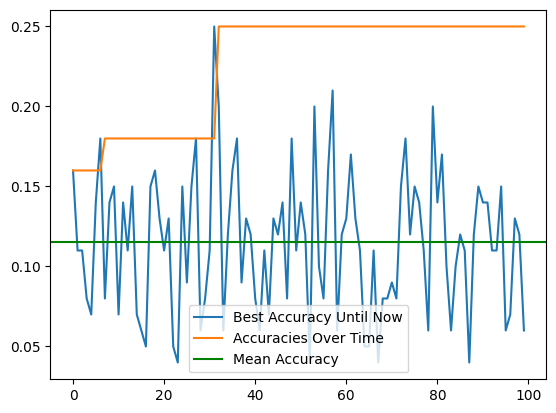

In [151]:
best_accuracies = [accuracies[0]]
best_accuracies += [np.max(accuracies[:i]) for i in range(1, len(accuracies))]
plt.plot(accuracies, label="Best Accuracy Until Now")
plt.plot(best_accuracies, label="Accuracies Over Time")
plt.axhline(np.mean(accuracies), label="Mean Accuracy", color="g")
plt.legend()
plt.show()

In [ ]:
GenomeMetricCallback = Callable[[Dict, keras.Model], Any]

def save_genome(data: Dict, model: keras.Model):
    key = "weights"
    if data.get(key) is None:
        data[key] = []
    data[key].append(copy.deepcopy(model.get_weights()))

# (µ + λ) strategy with tournament selection
def evolutionary_algorithm(
    num_generations: int,
    num_parents: int,
    num_children: int,
    tournament_size: int,
    num_tournament_winners: int,
    individual_constructor: Callable[[], Individual],
    fitness_eval: FitnessFunction,
    crossover: Crossover | None = None,
    mutations: List[Mutation] = [],
    genome_metric_callbacks: List[GenomeMetricCallback] = [],
):
    if num_tournament_winners > tournament_size:
        raise ValueError("Cannot have more tournament winners than participants")
        
    best_solution = None
    best_fitness = -np.inf
    genome_metrics = {"best_solution_fitness": np.zeros(num_generations)}
    
    # Create and evaluate the initial population
    population = []
    for _ in range(num_parents):
        individual = individual_constructor()
        fitness_eval(individual)
        if individual.fitness > best_fitness:
            best_solution = copy.deepcopy(individual)
            best_fitness = best_solution.fitness
        population.append(individual)
    
    for generation_index in range(num_generations):
        children = []
        while len(children) < num_children:
            parents = np.random.choice(population, 2)
            new_children = crossover(*parents) if crossover else list(map(Individual.copy_from, parents))
            
            for child in new_children:
                for mutation in mutations:
                    mutation(child)
                fitness_eval(child)
                if child.fitness > best_fitness:
                    best_solution = child
                    best_fitness = best_solution.fitness
            children.extend(new_children)
        population.extend(children)
        
        # Seed next generation with best solution found thus far
        next_generation = [best_solution]
        while len(next_generation) < num_parents:
            tournament = sorted(
                np.random.choice(population, size=tournament_size),
                key = lambda x: x.fitness,
                reverse=True,
            )
            next_generation.extend(tournament[:num_tournament_winners])
        population = next_generation
        
        for callback in genome_metric_callbacks:
            callback(genome_metrics, population)
        genome_metrics["best_solution_fitness"][generation_index] = best_fitness
        
    return genome_metrics
    

In [ ]:
# Sampling Mask (Indirect Encoding)

num_runs = 3

architecture = arch.Architecture('lenet', 'mnist')
features = [layer_sparsity_features, magnitude_features, random_features]
layers = [(4, 'relu')]

individual_constructor = functools.partial(
    Individual, 
    architecture=architecture,
    features=features,
    layers=layers,
)
fitness_eval = functools.partial(Individual.eval_sample_masks, num_evaluations=1)

mutations = [
    functools.partial(Individual.resample_prob, rate=1e-5),
    functools.partial(Individual.decrease_prob, rate=1e-4, scale=2.5e-2),
]
    
genome_metric_callbacks = [
    dummy_callback,
    average_sparsity_p,
]
kwargs = {
    "num_generations": 10,
    "num_parents": 10,
    "num_children": 10,
    "tournament_size": 4,
    "num_tournament_winners": 2,
    "individual_constructor": individual_constructor,
    # Construction kwargs
    "fitness_eval": fitness_eval,
    "mutations": mutations,
    "crossover": Individual.layer_crossover,
    "genome_metric_callbacks": genome_metric_callbacks,
}

indirect_encoding_metrics = []
for _ in range(num_runs):
    indirect_encoding_metrics.append(evolutionary_algorithm(**kwargs))